In [1]:
import numpy as np
import numba as nb

import time
import matplotlib.pyplot as plt
import socket

from IPython import display

In [18]:
hx = 18
hy = 18

buffer = np.zeros((hx, hy, 3), dtype='uint8')
buffer.shape

(18, 18, 3)

In [19]:
offset = hx * (hy // 2)

packet_1 = np.concatenate([np.array([0x04, 0xff, 0x00, 0x00], dtype='uint8'), 
                           np.zeros(offset * 3 , dtype='uint8')])
packet_2 = np.concatenate([np.array([0x04, 0xff, offset // 256,  offset  % 256], dtype='uint8'), 
                           np.zeros(offset * 3 , dtype='uint8')])

In [20]:
@nb.njit
def effect(buffer, t):
    for x in range(hx):
        for y in range(hy):
            dx = x / hx * 1.2
            dy = y / hy * 1.2
            buffer[x,y,0] = np.cos( dx * 2 + dy ** 2 * 6 + t) * 128 + 128
            buffer[x,y,1] = np.sin( dx * 3 + np.cos(t*1.42) ) * np.cos( (dy + np.sin(t*1.23)) * 4 ) * np.sin(t * 2.13) * 128 + 128
            buffer[x,y,2] = np.sin( dx ** 3 * 6 * np.cos(t*1.111) + dy * 4 + t * 3) * 128 + 128

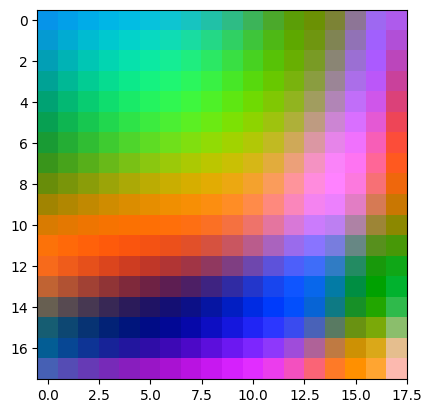

In [22]:
# Preview
for _ in range(100):
    t = time.time()

    effect(buffer, t)
    
    p = plt.imshow(np.swapaxes(buffer, 0, 1))
    display.clear_output(wait=True)
    plt.show(p)
    time.sleep(.012)

In [23]:
IP = '192.168.2.219'
#IP = '192.168.2.203'

PORT = 21324
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

In [24]:
# Real loop
n = 0
t0 = time.time()
dtotal = 0
dmin = 10
dmax = 0

while True:
    t = time.time()
    
    n+=1
    effect(buffer, t)
    
    if not n % 100:
        rate = 100 / (t - t0)
        t0 = time.time()
        print(f'sending rate={rate:.2f}, delay={dmin:.5f}..{dtotal/100:.5f}..{dmax:.5f}, fr={n} ', end='\r', flush=True)
        dtotal = 0
        dmin = 10
        dmax = 0

    packet_1[4:] = buffer[:hy//2, :, :].ravel()
    packet_2[4:] = buffer[hy//2:, :, :].ravel()

    try:
        sock.sendto(packet_1.data, (IP, PORT))
        sock.sendto(packet_2.data, (IP, PORT))
    except OSError as e:
        print(e)
        time.sleep(10)
    
    diff = time.time() - t
    dtotal += diff
    dmin = min(dmin, diff)
    dmax = max(dmax, diff)
    
    if diff > .02:
        print(n, diff, '')
        
    if diff < .02:
        time.sleep(.02 - diff)

[Errno 64] Host is down


KeyboardInterrupt: 